In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [12]:
# autoreload
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from magnet_pinn.data.grid import MagnetGridIterator
from magnet_pinn.data.transforms import Crop, GridPhaseShift, Compose, DefaultTransform
from magnet_pinn.data.dataitem import DataItem

from src.colors import NEURALPDE_COLORMAP
from src.sar import SARcompute

In [14]:
augmentation = Compose(
    [
        Crop(crop_size=(70, 70, 70)),
        GridPhaseShift(num_coils=8)
    ]
)


iterator = MagnetGridIterator(
    "/home/andi/coding/data/magnet/processed/single_batch_old/grid_voxel_size_4_data_type_float32",
    transforms=augmentation,
    num_samples=1,
)

simulation = next(iter(iterator))
simulation = DataItem(**simulation)


In [15]:
class ObjectMaskPadding:
    def __init__(self, padding: int = 1):
        self.padding = padding
        self.padding_filter = torch.ones([1,1] + [self.padding*2 + 1]*3, dtype=torch.float32)

    def __call__(self, input_shape_mask: torch.Tensor) -> torch.Tensor:
        check_border = torch.nn.functional.conv3d(input_shape_mask.type(torch.float32), self.padding_filter, padding=self.padding)
        return check_border == torch.sum(self.padding_filter)

In [16]:
field = simulation.field
subject = simulation.subject
properties = simulation.input
coils = simulation.coils

In [17]:
def calculate_b1_plus(b_field):
    # b_x + i*b_y
    b_field_complex = b_field[0] + 1j*b_field[1]
    b1_plus = 0.5*(b_field_complex[0] + 1j*b_field_complex[1])
    return np.stack([b1_plus.real, b1_plus.imag], axis=0)

b1_plus = calculate_b1_plus(field[1])


In [18]:
# unwrap properties
conductivity, permittivity, density = properties
conductivity += 1e-6

# norm of coils
coils_re = coils[0]
coils_im = coils[1]

# abs field
abs_efield = np.linalg.norm(field[0], axis=(0,1))
abs_efield = abs_efield

# abs hfield
abs_hfield = np.linalg.norm(field[1], axis=(0,1))

# compute SAR
sar_compute = SARcompute(mass_average=10, expand_intermediates=9)
sar, pointwise_sar = sar_compute(simulation)

(10, 10, 10)


100%|██████████| 343/343 [00:01<00:00, 173.89it/s]


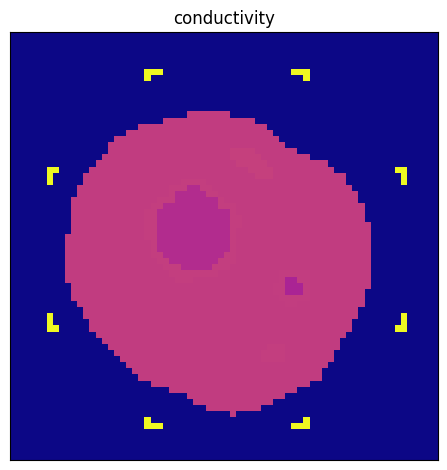

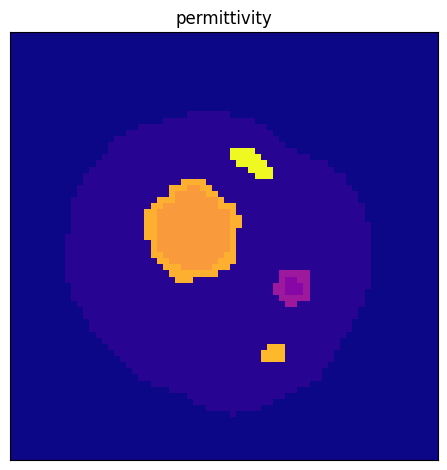

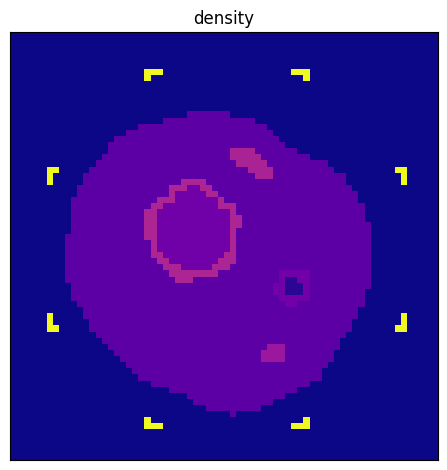

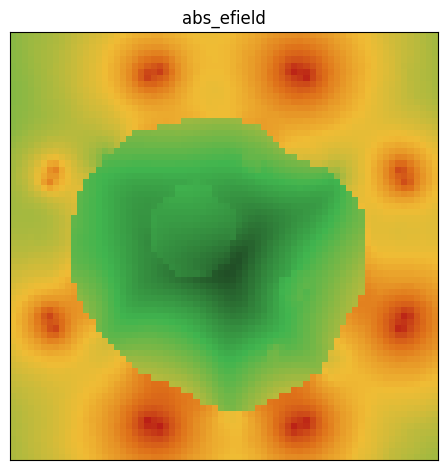

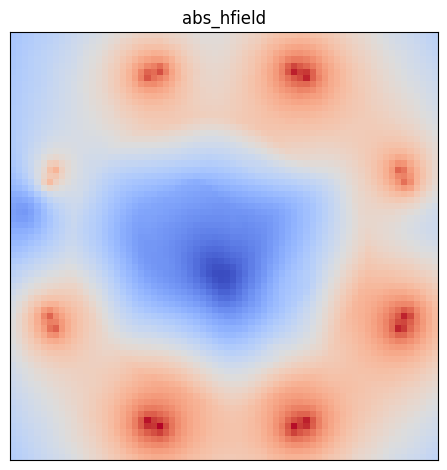

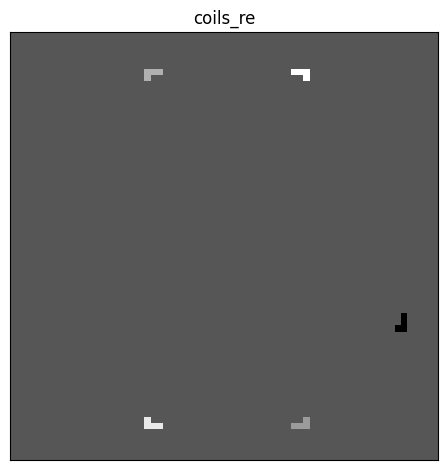

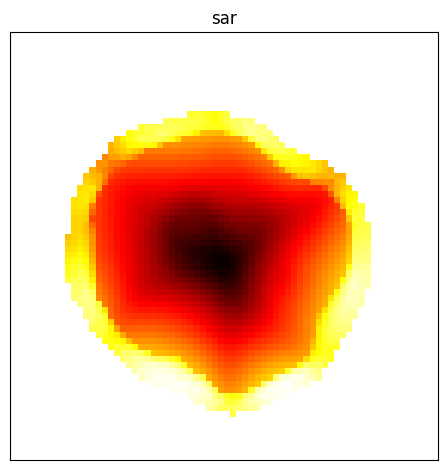

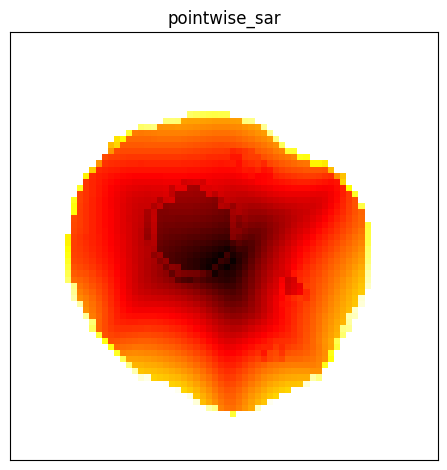

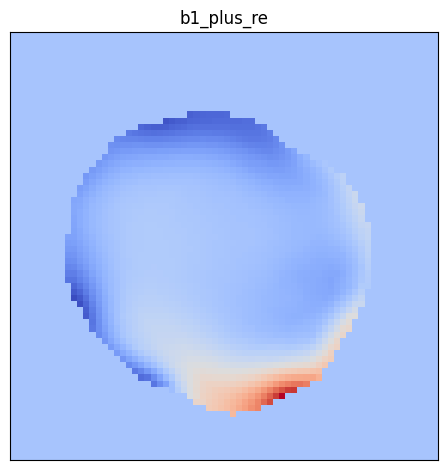

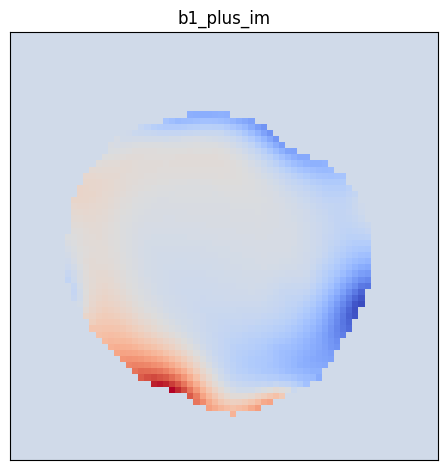

In [19]:
import matplotlib.pyplot as plt

slice_id = 31
features_to_plot = {
    "conductivity": conductivity,
    "permittivity": permittivity,
    "density": density,
    "abs_efield": abs_efield,
    "abs_hfield": abs_hfield,
    "coils_re": coils_re,
    "sar": sar,
    "pointwise_sar": pointwise_sar,
    "b1_plus_re": b1_plus[0]*subject,
    "b1_plus_im": b1_plus[1]*subject,
}
num_features = len(features_to_plot)
i = 0
for name, feature in features_to_plot.items():
    fig, ax = plt.subplots()
    norm = None
    if name == "coils_re":
        cmap = 'gray'
    elif name == "abs_efield":
        cmap = NEURALPDE_COLORMAP
        norm = 'log'
    elif name == "abs_hfield":
        cmap = 'coolwarm'
        norm = 'log'
    elif name == "conductivity":
        norm = 'log'
        cmap = 'plasma'
    elif name == "sar":
        norm = 'log'
        cmap = 'hot'
    elif name == "pointwise_sar":
        norm = 'log'
        cmap = 'hot'
    elif name == "b1_plus_re":
        cmap = 'coolwarm'
        norm = None
    elif name == "b1_plus_im":
        cmap = 'coolwarm'
        norm = None
    else:
        cmap = 'plasma'
    ax.imshow(feature[:,:,slice_id], cmap=cmap, norm=norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(name)
    fig.tight_layout()
    fig.savefig(f"figures/{name}_{slice_id}.png", bbox_inches='tight', pad_inches=0)


In [20]:
field = simulation['field']
subject = simulation['subject']
# pad subject
object_mask_padding = ObjectMaskPadding(padding=1)
subject = torch.tensor(subject, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
subject = object_mask_padding(subject)
subject = subject.squeeze(0).squeeze(0).cpu().numpy()
abs_efield = np.linalg.norm(field[0], axis=(0,1))
abs_efield = abs_efield*subject

TypeError: 'DataItem' object is not subscriptable

In [ ]:
# make 3d plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([100, 100, 200])

def add_surface(ax, slice_idx, data):
    # add a surface along the x axis with the field data sliced along this axis
    x = np.arange(-50, 50, 1)
    y = np.arange(-50, 50, 1)
    x, y = np.meshgrid(x, y)
    z = np.zeros_like(x) + slice_idx - 50

    max_efield = np.max(data)
    min_efield = np.min(data)

    cmap = plt.get_cmap('viridis')

    normalized_values = np.log(((data - min_efield) / (max_efield - min_efield))*(np.e - 1) + 1)
    facecolors = cmap(normalized_values[:,:,slice_idx])
    ax.plot_surface(x, y, z, cmap='viridis', facecolors=facecolors)

add_surface(ax, 30, abs_efield)
add_surface(ax, 40, abs_efield)
add_surface(ax, 50, abs_efield)
add_surface(ax, 60, abs_efield)
plt.show()

In [ ]:
# plot the slices

fig1 = go.Figure(data=[slice_z, slice_y])
fig1.update_layout(
         title_text='Slices in volumetric data', 
         title_x=0.5,
         width=700,
         height=700,
         scene_zaxis_range=[-2,2], 
         coloraxis=dict(colorscale='BrBG',
                        colorbar_thickness=25,
                        colorbar_len=0.75,
                        **colorax(vmin, vmax)))            
      
fig1.show()  